# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:45<00:00, 1942.43it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

# Processing Texts from summary

In [25]:
preprocessed_reviews_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

100%|██████████| 87773/87773 [00:28<00:00, 3083.28it/s]


# Including Texts from summary in the main text

In [26]:
preprocessed_reviews_fe = []
for i in tqdm(range(0,len(preprocessed_reviews_summary))):
    preprocessed_reviews_fe.append(preprocessed_reviews_summary[i]+" "+ preprocessed_reviews[i])

100%|██████████| 87773/87773 [00:00<00:00, 770598.81it/s]


# Adding length of text as a feature

In [27]:
preprocessed_reviews_fe_final = []
for i in tqdm(preprocessed_reviews_fe):
    count = 0;
    for j in i.split(" "):
        count += 1;
    i = i + " " + str(count);
    preprocessed_reviews_fe_final.append(i)

100%|██████████| 87773/87773 [00:01<00:00, 84100.63it/s] 


# Test - Train Split

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews_fe_final, final['Score'], test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


## [4.1] BAG OF WORDS

In [29]:
count_vect = CountVectorizer( min_df = 10) #in scikit-learn

X_train_vect = count_vect.fit_transform(X_train)
# X_train_vect = X_train_vect.toarray()
X_cv_vect = count_vect.transform(X_cv)
# X_cv_vect = X_cv_vect.toarray()
X_test_vect = count_vect.transform(X_test)
# X_test_vect = X_test_vect.toarray()

## [4.2] Bi-Garams and n-Grams.

## [4.3] TF-IDF

In [39]:
tf_idf = TfidfVectorizer(min_df = 10)
X_train_vect_tfidf = tf_idf.fit_transform(X_train)
# X_train_vect_tfidf = X_train_vect_tfidf.toarray()
X_test_vect_tfidf = tf_idf.transform(X_test)
# X_test_vect_tfidf = X_test_vect_tfidf.toarray()
X_cv_vect_tfidf = tf_idf.transform(X_cv)
# X_cv_vect_tfidf = X_cv_vect_tfidf.toarray()

## [4.4] Word2Vec

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [40]:
# average Word2Vec
# compute average word2vec for each review.
i=0
list_of_sent=[]
X_train_list=[]
X_test_list=[]
X_cv_list=[]
for sent in X_train:
    X_train_list.append(sent.split())
    
for sent in X_cv:
    X_cv_list.append(sent.split())
    
for sent in X_test:
    X_test_list.append(sent.split())
    
w2v_model=Word2Vec(X_train_list,min_count=0,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

X_train_vectors = [];
for sent in tqdm(X_train_list): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_vectors.append(sent_vec)
    

X_cv_vectors = []
for sent in tqdm(X_cv_list): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_vectors.append(sent_vec)
    
X_test_vectors = []
for sent in tqdm(X_test_list): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_vectors.append(sent_vec)

100%|██████████| 28966/28966 [02:01<00:00, 239.24it/s]


#### [4.4.1.2] TFIDF weighted W2v

In [55]:

dictionary = dict(zip(tf_idf.get_feature_names(), list(tf_idf.idf_)))
tfidf_feat = tf_idf.get_feature_names()
tfidf_X_train_vectors = [];
tfidf_X_test_vectors = [];
tfidf_X_cv_vectors = [];

for sent in tqdm(X_train_list):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in (w2v_words and tfidf_feat):
            vec = w2v_model.wv[word]
            tf_idf_count = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf_count)
            weight_sum += tf_idf_count
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_X_train_vectors.append(sent_vec)

for sent in tqdm(X_test_list):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in (w2v_words and tfidf_feat):
            vec = w2v_model.wv[word]
            tf_idf_count = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf_count)
            weight_sum += tf_idf_count
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_X_test_vectors.append(sent_vec)
    
for sent in tqdm(X_cv_list):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in (w2v_words and tfidf_feat):
            vec = w2v_model.wv[word]
            tf_idf_count = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf_count)
            weight_sum += tf_idf_count
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_X_cv_vectors.append(sent_vec)

100%|██████████| 19407/19407 [01:29<00:00, 218.00it/s]


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

depth_in_range = [1,5,10,50,100,500,1000]
min_sample_split = [5,10,100,500]

parameters = [{'max_depth': [1,5,10,50,100,500,1000]},{'min_samples_split':[5,10,100,500]}]

model = GridSearchCV(DecisionTreeClassifier(),parameters, scoring = 'roc_auc')
model.fit(X_train_vect, y_train)

print(model.best_estimator_)
print(model.score(X_test_vect, y_test))


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8222850251641352


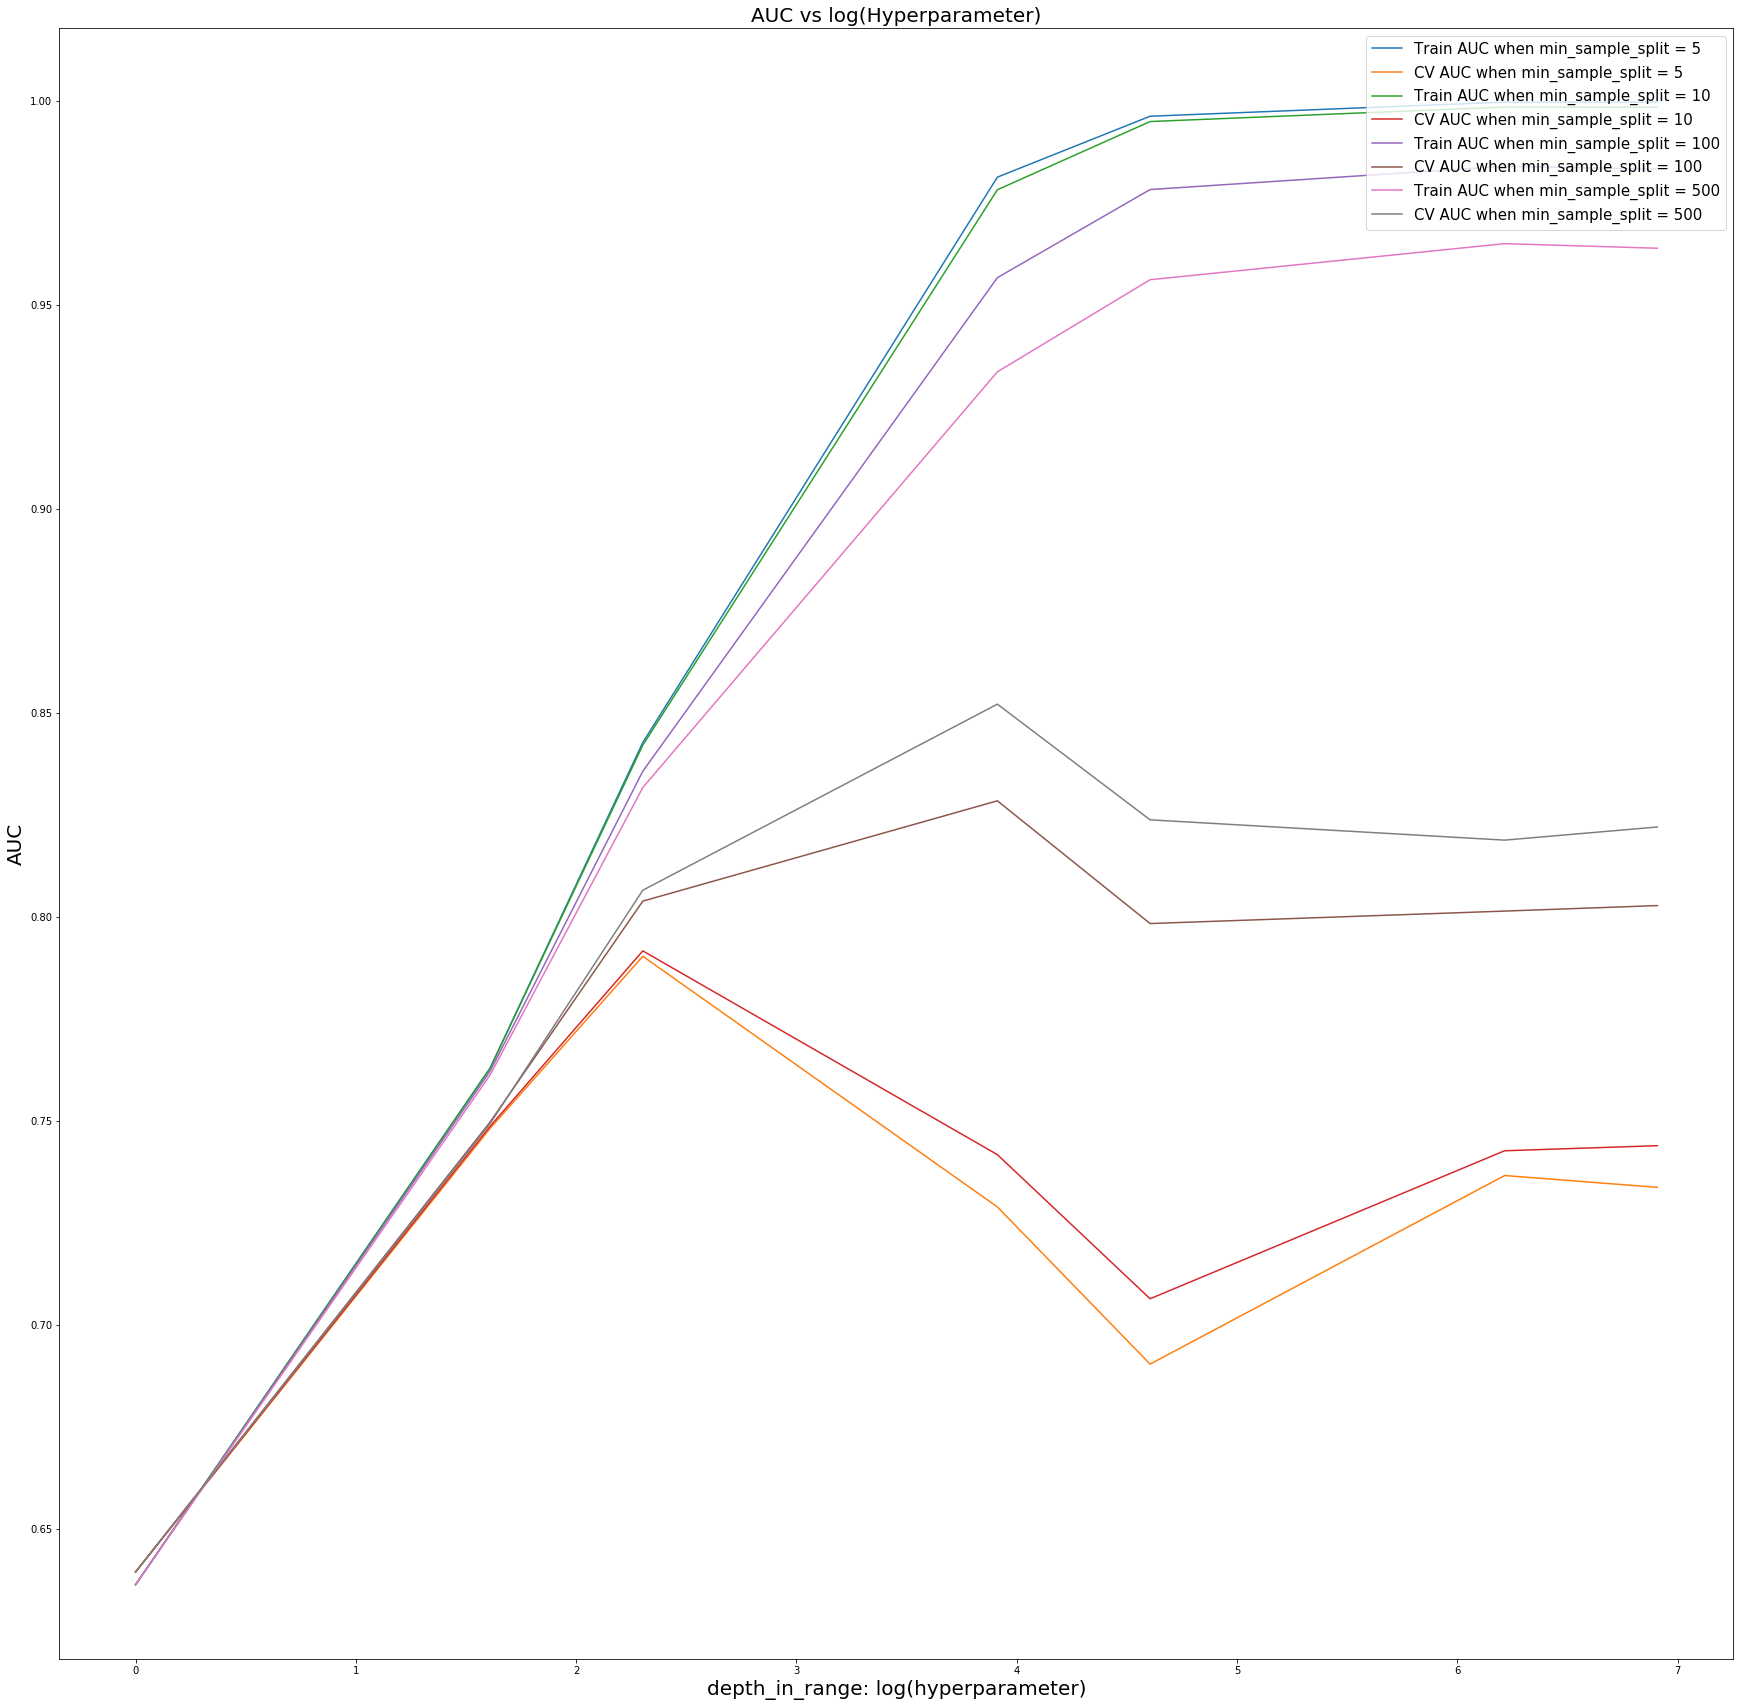

In [32]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
depth_in_range = [1,5,10,50,100,500,1000]
min_sample_split = [5,10,100,500]
ind = []
train_auc = []
cv_auc = []


plt.figure(figsize=(30,30))
for i in (min_sample_split):
    cv_auc_plot = []
    train_auc_plot = []
    for j in (depth_in_range):
        dtc = DecisionTreeClassifier(max_depth = j,min_samples_split = i)
        dtc.fit(X_train_vect, y_train)
        y_train_pred =  dtc.predict_proba(X_train_vect)[:,1]
        y_cv_pred =  dtc.predict_proba(X_cv_vect)[:,1]
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        train_auc_plot.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        cv_auc_plot.append(roc_auc_score(y_cv, y_cv_pred))

    plt.plot(np.log(depth_in_range), train_auc_plot, label='Train AUC when min_sample_split = ' + str(i))
    plt.plot(np.log(depth_in_range), cv_auc_plot, label='CV AUC when min_sample_split = ' + str(i))
    
plt.legend(loc=1, prop={'size': 15})
plt.xlabel("depth_in_range: log(hyperparameter)",fontsize = 20)
plt.ylabel("AUC",fontsize = 20)
plt.title("AUC vs log(Hyperparameter)",fontsize = 20)
plt.show()




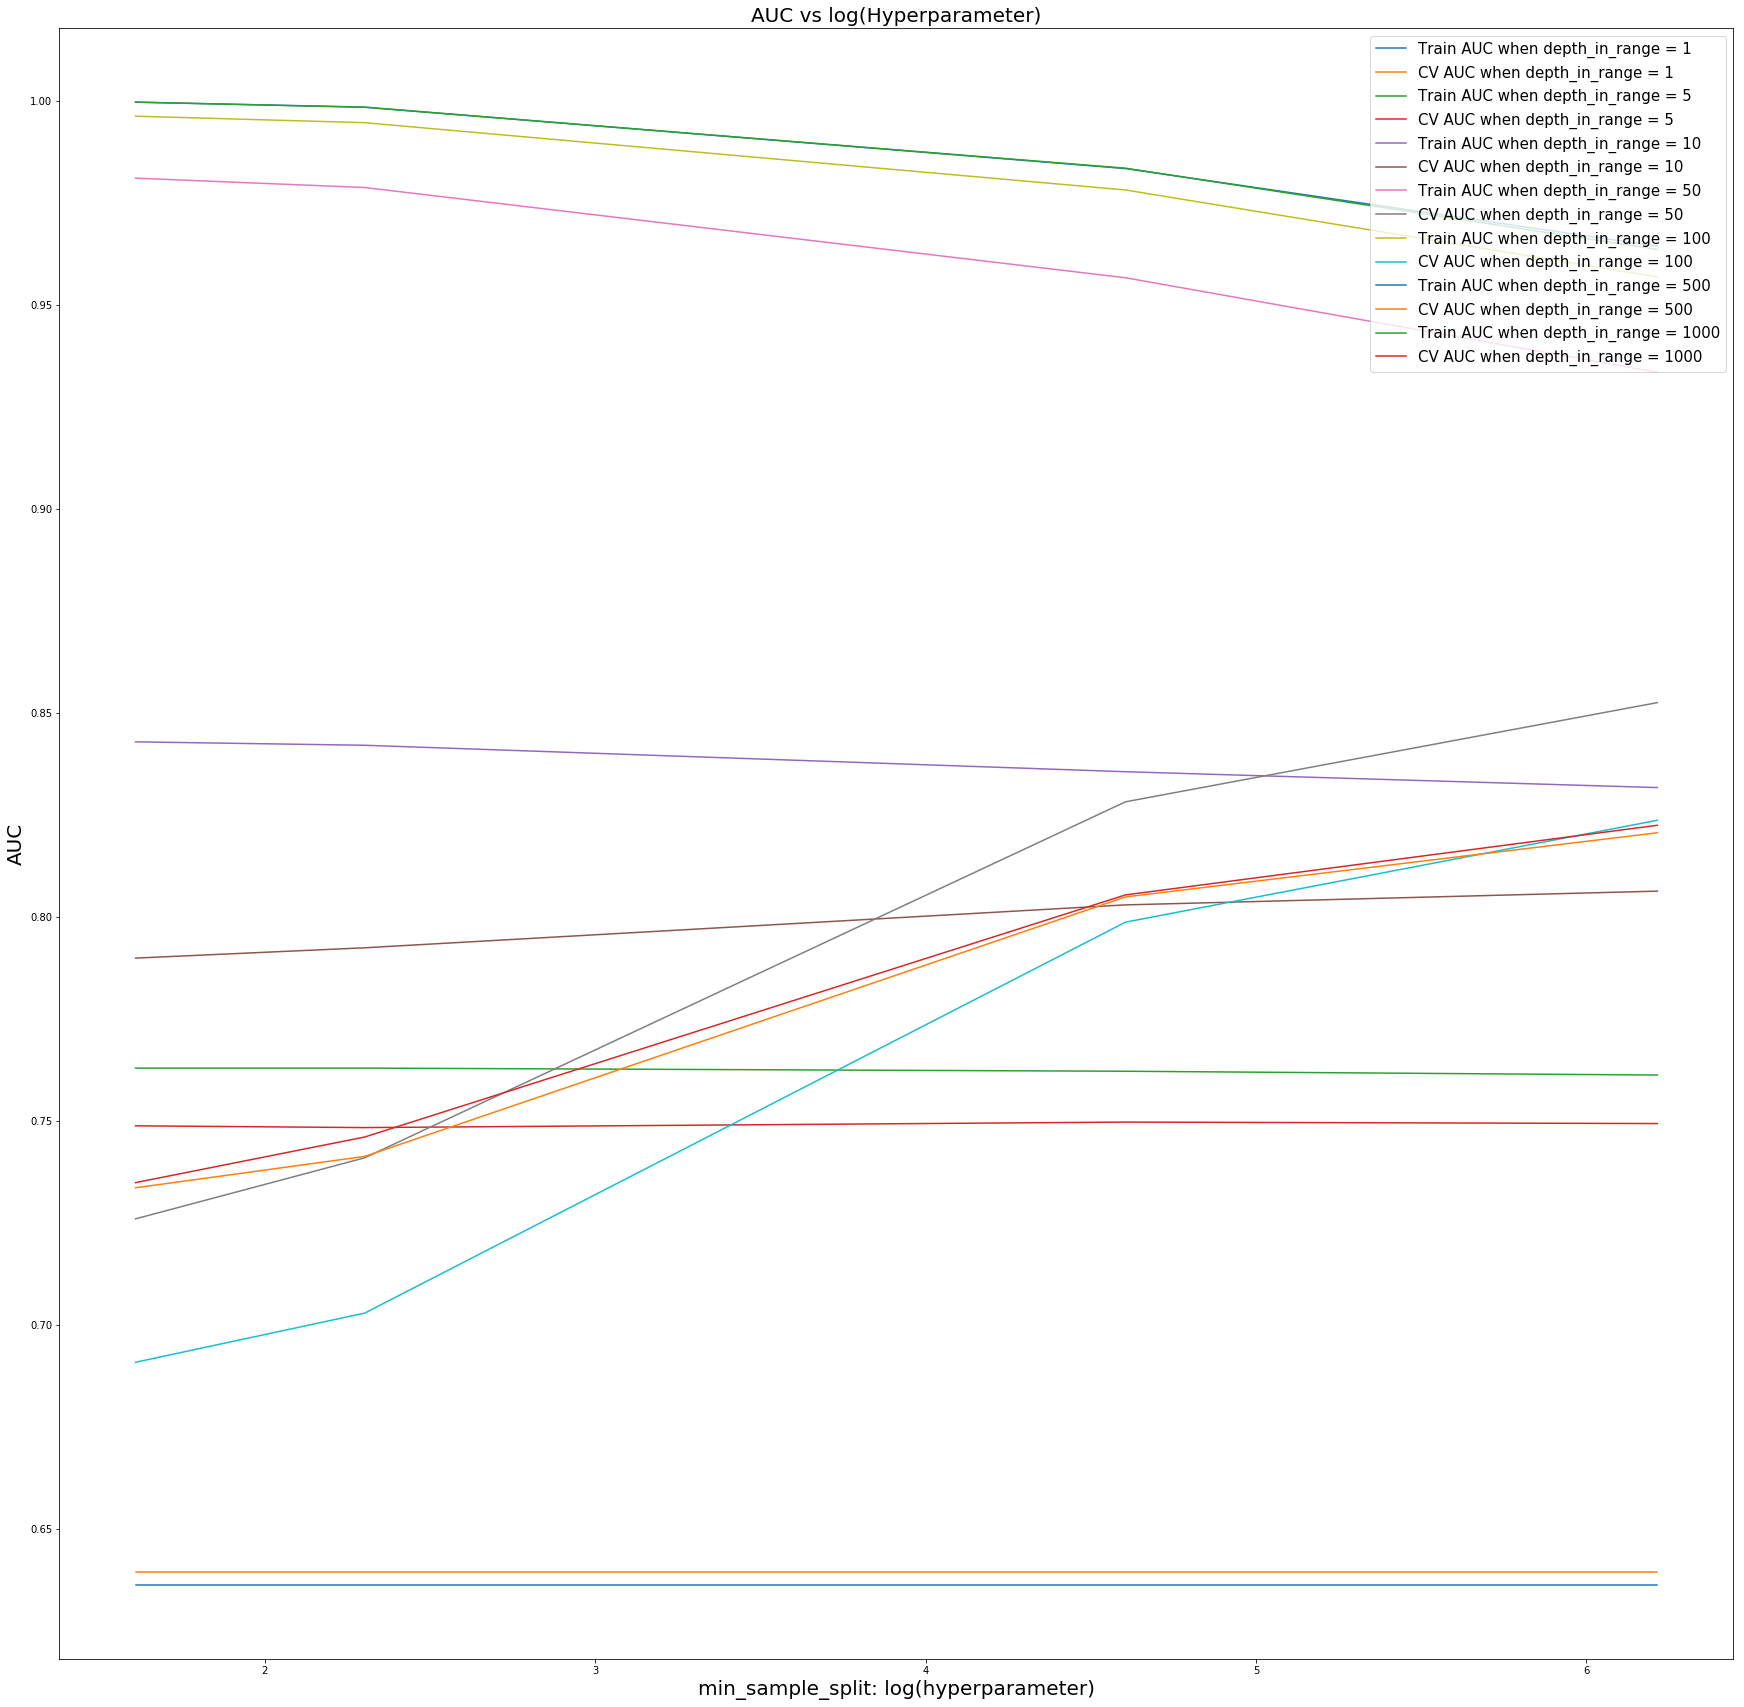

In [34]:

depth_in_range = [1,5,10,50,100,500,1000]
min_sample_split = [5,10,100,500]
count = 0;
ind = []
train_auc = []
cv_auc = []
hyp = []

plt.figure(figsize=(30,30))
for i in (depth_in_range):
    cv_auc_plot = []
    train_auc_plot = []
    for j in (min_sample_split):
        dtc = DecisionTreeClassifier(max_depth = i,min_samples_split = j)
        dtc.fit(X_train_vect, y_train)
        ind.append(count)
        hyp.append([i,j])
        y_train_pred =  dtc.predict_proba(X_train_vect)[:,1]
        y_cv_pred =  dtc.predict_proba(X_cv_vect)[:,1]
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        train_auc_plot.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        cv_auc_plot.append(roc_auc_score(y_cv, y_cv_pred))
        count += 1
    

    plt.plot(np.log(min_sample_split), train_auc_plot, label='Train AUC when depth_in_range = ' + str(i))
    plt.plot(np.log(min_sample_split), cv_auc_plot, label='CV AUC when depth_in_range = ' + str(i))
    
plt.legend(loc=1, prop={'size': 15})
plt.xlabel("min_sample_split: log(hyperparameter)",fontsize = 20)
plt.ylabel("AUC",fontsize = 20)
plt.title("AUC vs log(Hyperparameter)",fontsize = 20)
plt.show()

In [35]:
optimal_alpha_auc = hyp[cv_auc.index(max(cv_auc))]
print('\nThe optimal max_depth is (according to auc curve (max auc)): ' , optimal_alpha_auc[0])
print('\nThe optimal min_sample_split is (according to auc curve (max auc)): ' , optimal_alpha_auc[1])



The optimal max_depth is (according to auc curve (max auc)):  50

The optimal min_sample_split is (according to auc curve (max auc)):  500



****Test accuracy formax_depth = 50.000000 and min_samples_split = 500.000000 is 86.712007%


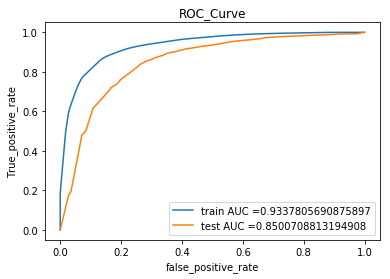

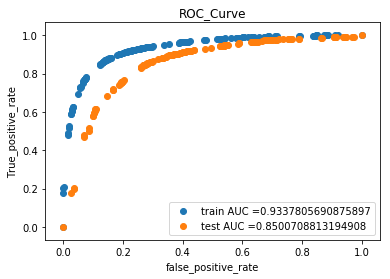

In [70]:
dtc = DecisionTreeClassifier(max_depth = optimal_alpha_auc[0],min_samples_split = optimal_alpha_auc[1])
dtc.fit(X_train_vect, y_train)
pred = dtc.predict(X_test_vect)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy formax_depth = %f and min_samples_split = %f is %f%%' % (optimal_alpha_auc[0],optimal_alpha_auc[1],acc))


train_fpr, train_tpr, thresholds = roc_curve(y_train, dtc.predict_proba(X_train_vect)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, dtc.predict_proba(X_test_vect)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)



Train confusion matrix
[[ 3881  2494]
 [ 1234 31791]]


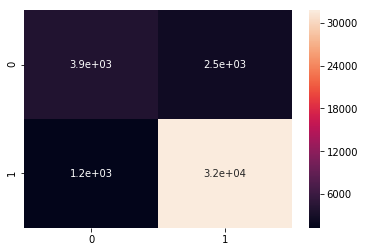

In [73]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cm_tr = confusion_matrix(y_train, dtc.predict(X_train_vect))
sns.heatmap(cm_tr, annot=True)
print(cm_tr)

Train confusion matrix
[[ 2197  2474]
 [ 1375 22920]]


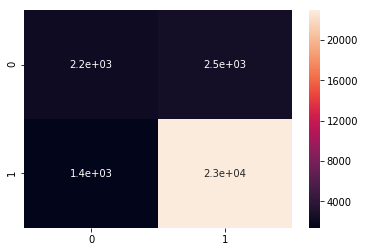

In [71]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cm_tr = confusion_matrix(y_test, dtc.predict(X_test_vect))
sns.heatmap(cm_tr, annot=True)
print(cm_tr)

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [37]:
# Please write all the code with proper documentation
imp  = dtc.feature_importances_ 

vocab = list(count_vect.get_feature_names())
imp_features = list(imp)
dict_new = {'Words':vocab,'imp_features':imp_features}
df_new = pd.DataFrame(dict_new)
df_pos_sorted =df_new.sort_values('imp_features', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
print("The top 20 important features are the following:")
print(df_pos_sorted[0:20])
print("\n")

The top 20 important features are the following:
             Words  imp_features
4820           not      0.116744
3217         great      0.082265
2148  disappointed      0.042088
746           best      0.038781
589          awful      0.036649
1985     delicious      0.033273
3496      horrible      0.032353
4232          love      0.030641
3156          good      0.029527
7280      terrible      0.021394
5211       perfect      0.019686
605            bad      0.018714
4237         loves      0.017881
2567     excellent      0.016515
4781          nice      0.016468
8054         worst      0.014755
7218         tasty      0.012683
7886         waste      0.012661
2711      favorite      0.011340
4616         money      0.010273




### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

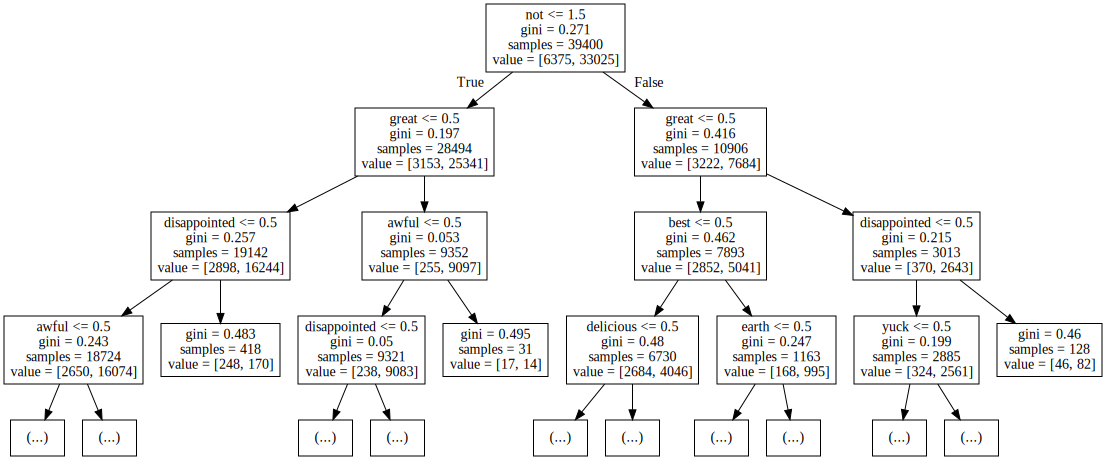

In [38]:
import graphviz
from sklearn import tree
import os
dot_data = tree.export_graphviz(dtc, out_file= None, max_depth=3, feature_names = vocab) 
graph = graphviz.Source(dot_data)
graph

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

depth_in_range = [1,5,10,50,100,500,1000]
min_sample_split = [5,10,100,500]

parameters = [{'max_depth': [1,5,10,50,100,500,1000]},{'min_samples_split':[5,10,100,500]}]

model = GridSearchCV(DecisionTreeClassifier(),parameters, scoring = 'roc_auc')
model.fit(X_train_vect_tfidf, y_train)

print(model.best_estimator_)
print(model.score(X_test_vect_tfidf, y_test))


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8121771397203316


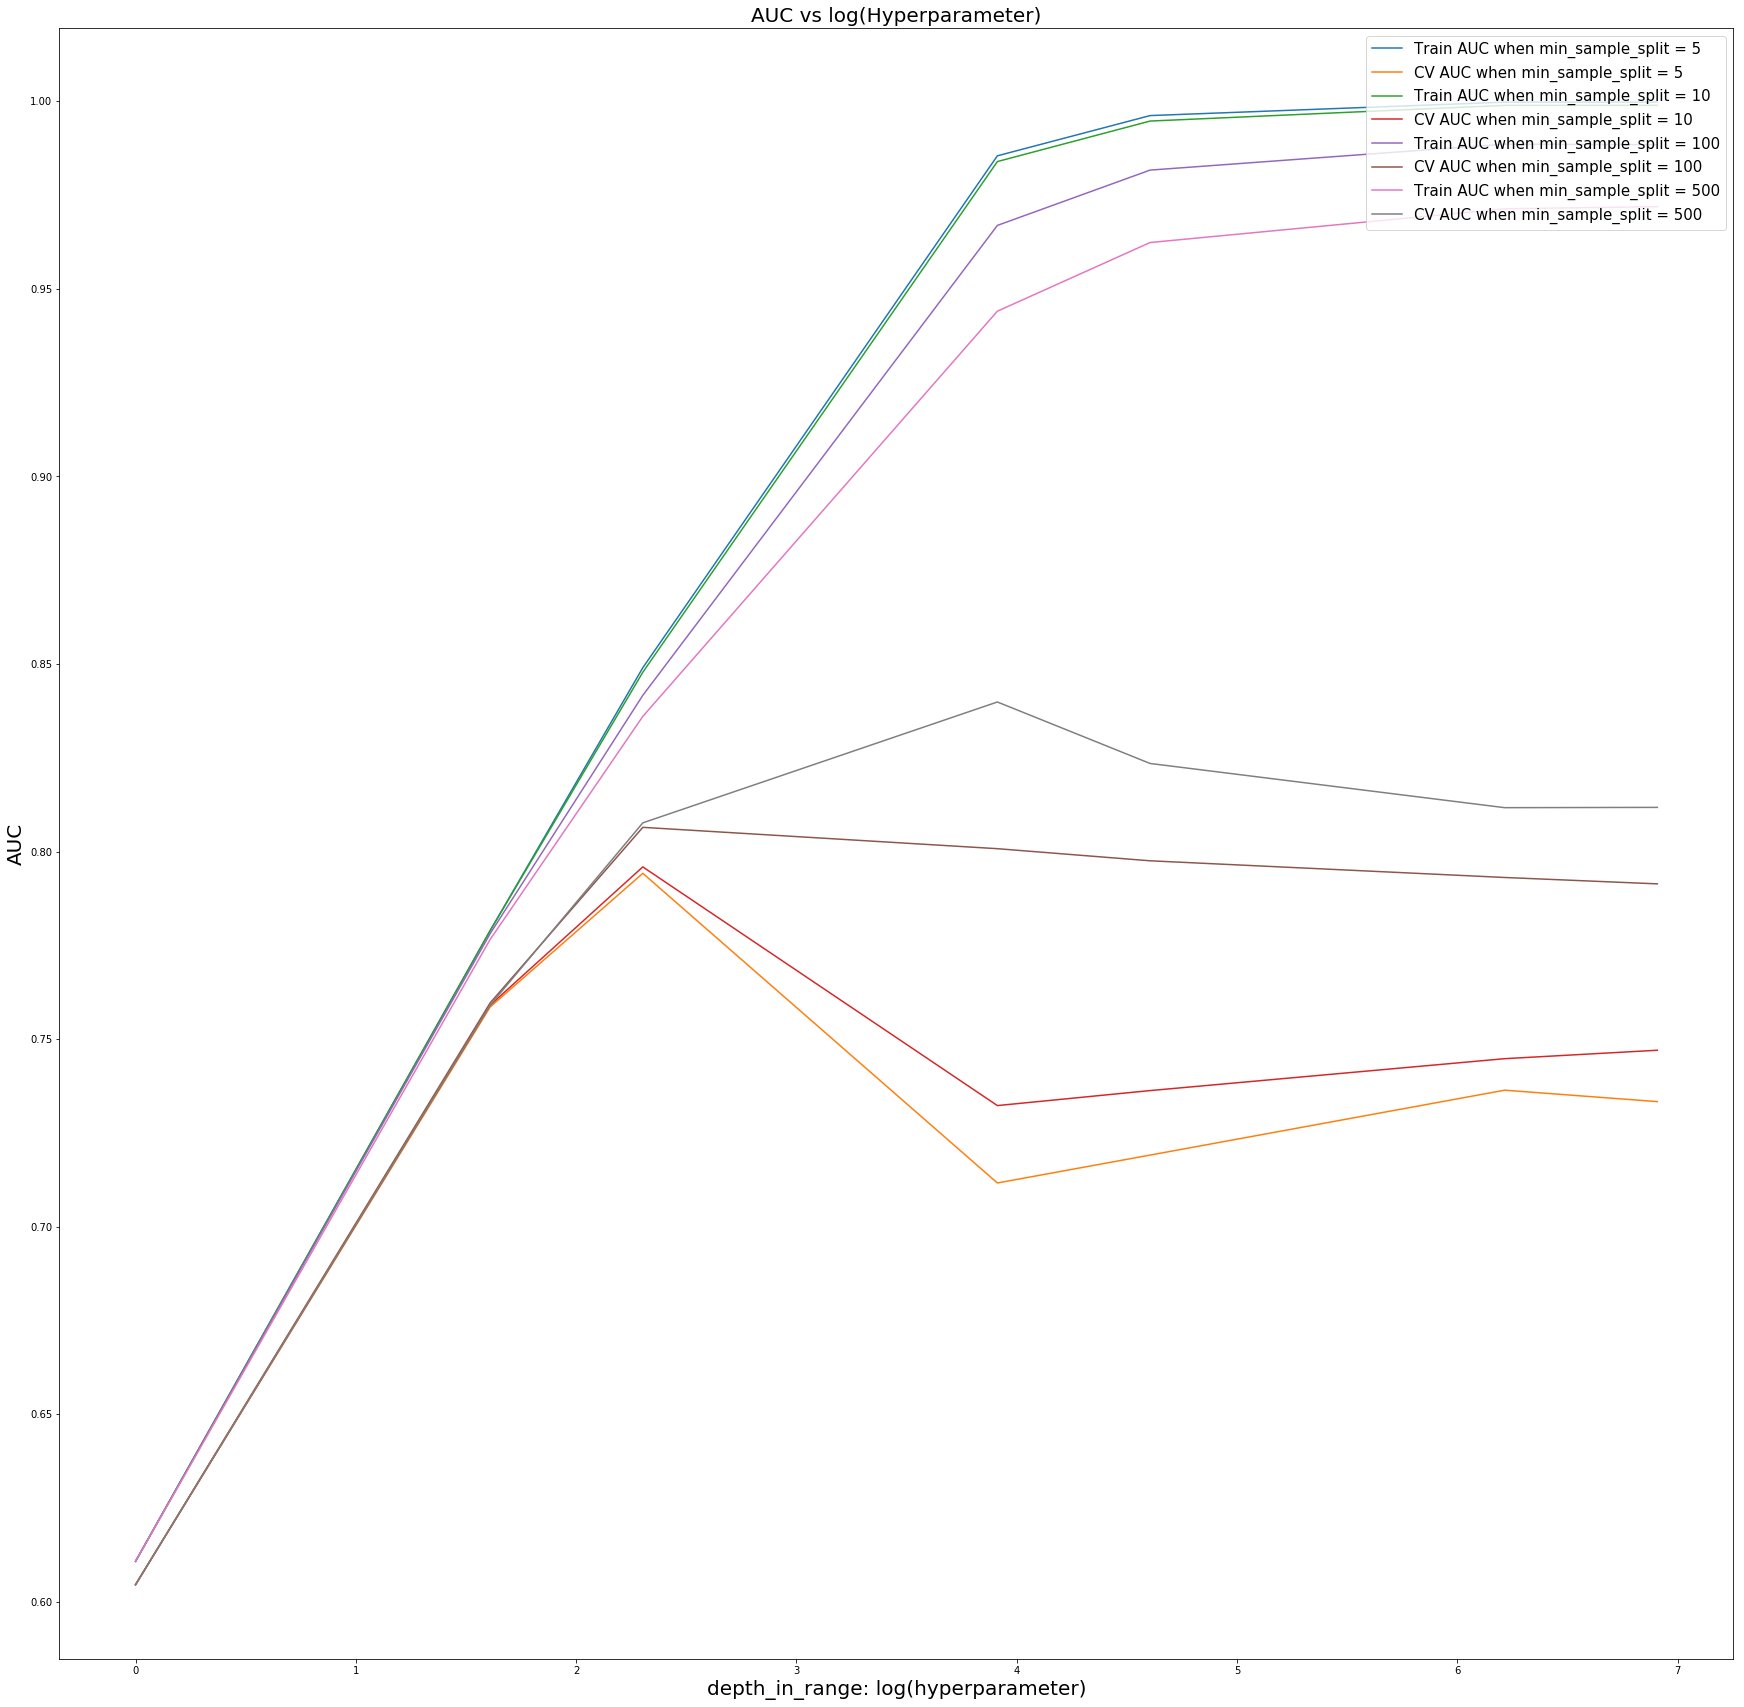

In [43]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
depth_in_range = [1,5,10,50,100,500,1000]
min_sample_split = [5,10,100,500]
ind = []
train_auc = []
cv_auc = []


plt.figure(figsize=(30,30))
for i in (min_sample_split):
    cv_auc_plot = []
    train_auc_plot = []
    for j in (depth_in_range):
        dtc = DecisionTreeClassifier(max_depth = j,min_samples_split = i)
        dtc.fit(X_train_vect_tfidf, y_train)
        y_train_pred =  dtc.predict_proba(X_train_vect_tfidf)[:,1]
        y_cv_pred =  dtc.predict_proba(X_cv_vect_tfidf)[:,1]
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        train_auc_plot.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        cv_auc_plot.append(roc_auc_score(y_cv, y_cv_pred))

    plt.plot(np.log(depth_in_range), train_auc_plot, label='Train AUC when min_sample_split = ' + str(i))
    plt.plot(np.log(depth_in_range), cv_auc_plot, label='CV AUC when min_sample_split = ' + str(i))
    
plt.legend(loc=1, prop={'size': 15})
plt.xlabel("depth_in_range: log(hyperparameter)",fontsize = 20)
plt.ylabel("AUC",fontsize = 20)
plt.title("AUC vs log(Hyperparameter)",fontsize = 20)
plt.show()




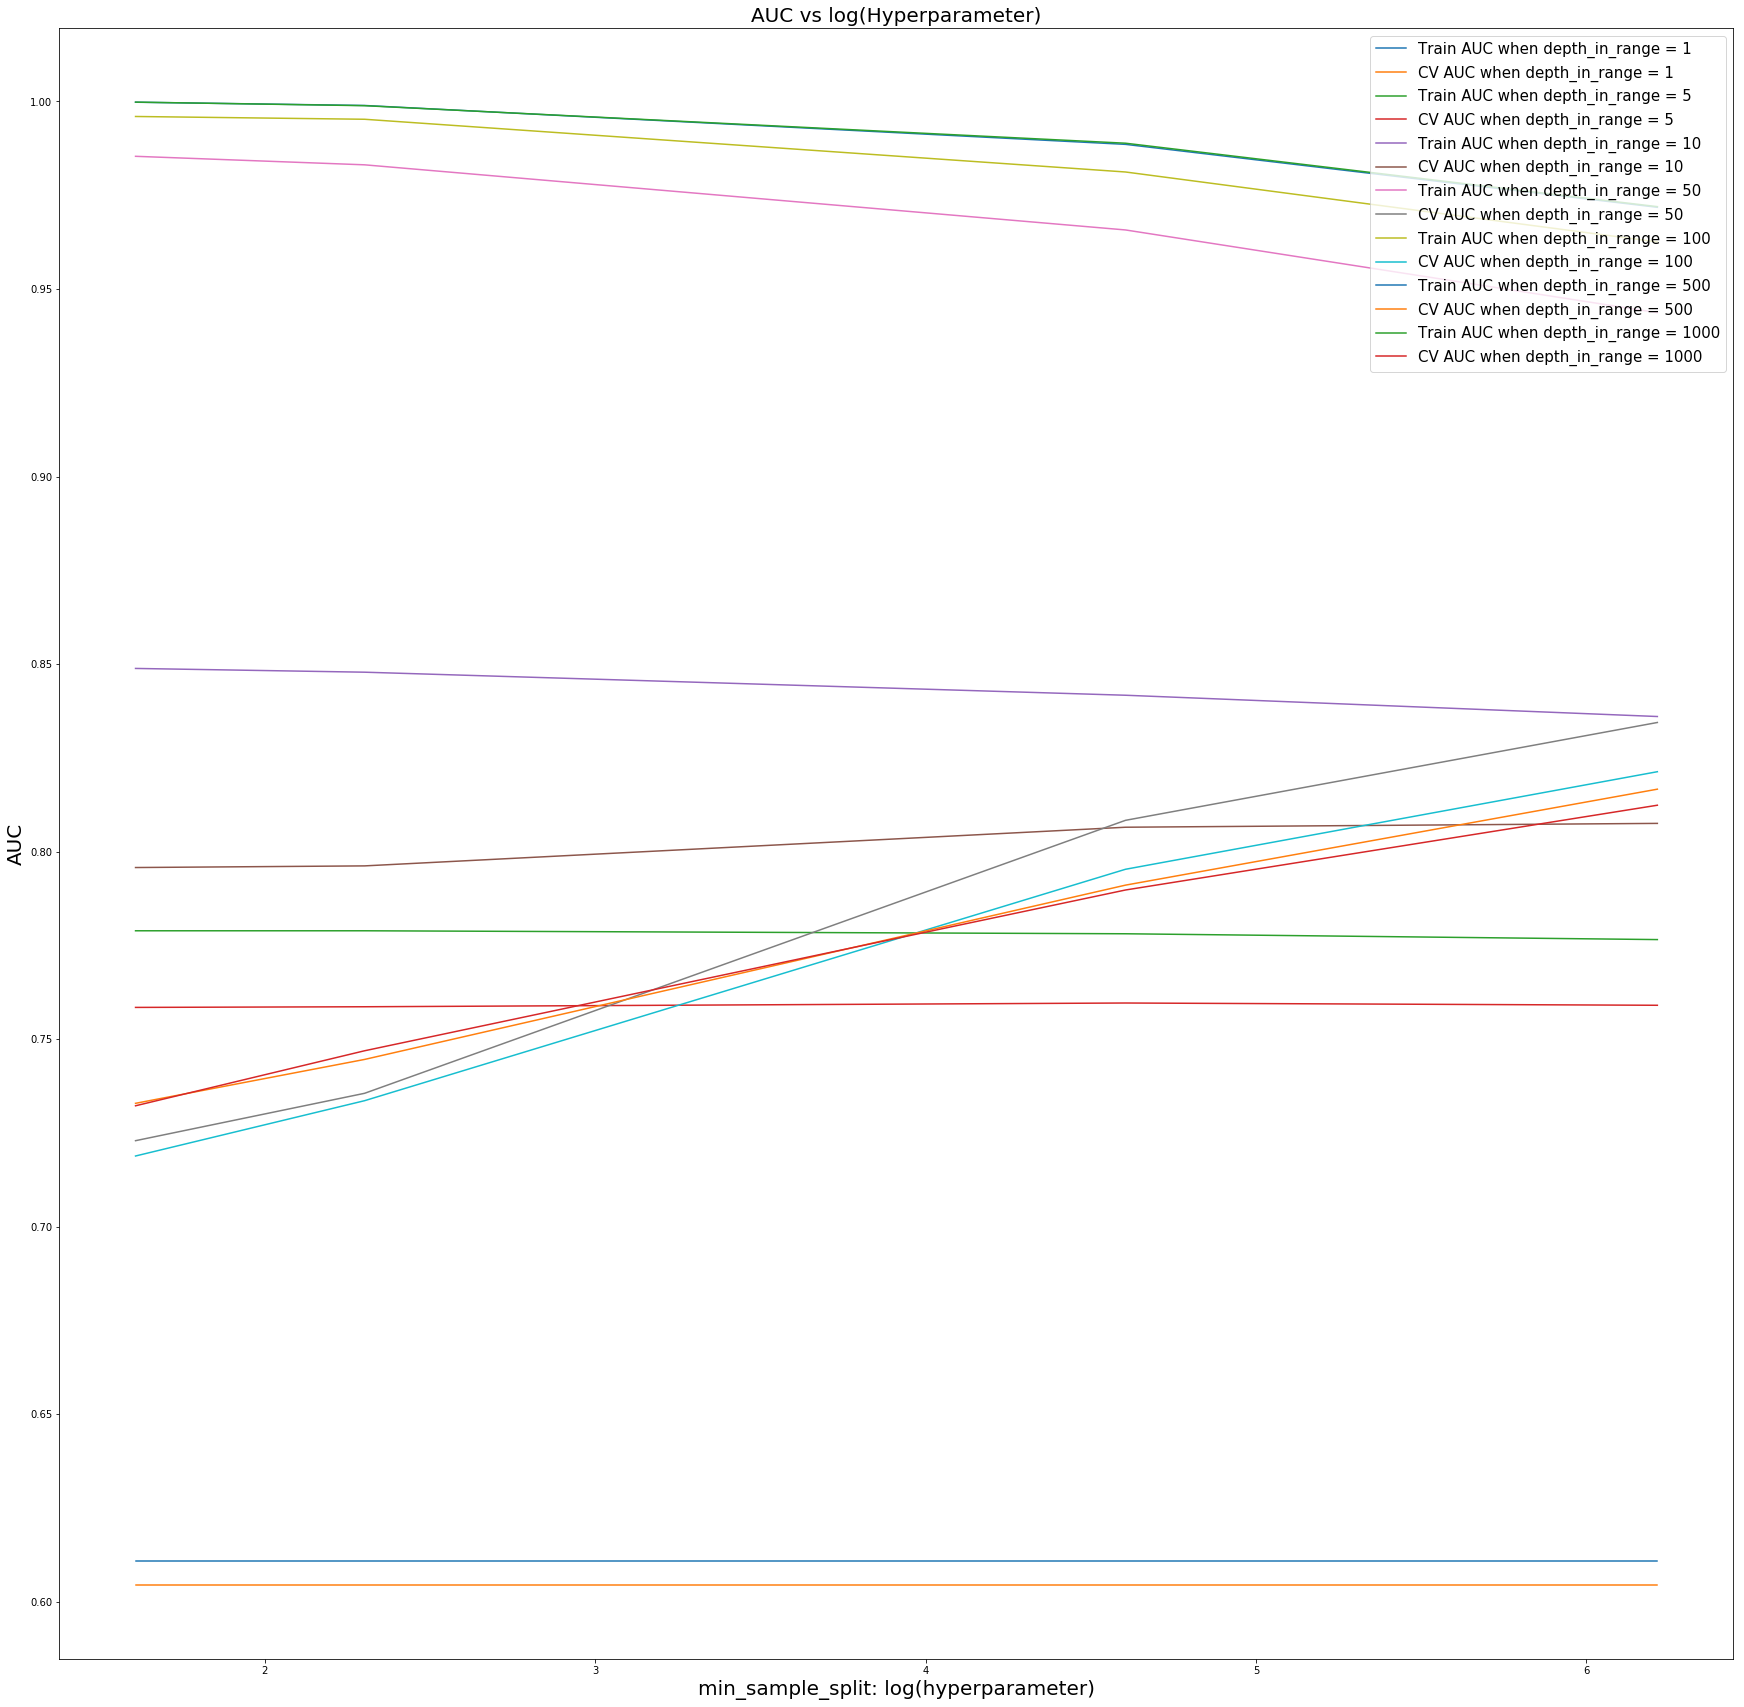

In [44]:

depth_in_range = [1,5,10,50,100,500,1000]
min_sample_split = [5,10,100,500]
count = 0;
ind = []
train_auc = []
cv_auc = []
hyp = []

plt.figure(figsize=(30,30))
for i in (depth_in_range):
    cv_auc_plot = []
    train_auc_plot = []
    for j in (min_sample_split):
        dtc = DecisionTreeClassifier(max_depth = i,min_samples_split = j)
        dtc.fit(X_train_vect_tfidf, y_train)
        ind.append(count)
        hyp.append([i,j])
        y_train_pred =  dtc.predict_proba(X_train_vect_tfidf)[:,1]
        y_cv_pred =  dtc.predict_proba(X_cv_vect_tfidf)[:,1]
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        train_auc_plot.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        cv_auc_plot.append(roc_auc_score(y_cv, y_cv_pred))
        count += 1
    

    plt.plot(np.log(min_sample_split), train_auc_plot, label='Train AUC when depth_in_range = ' + str(i))
    plt.plot(np.log(min_sample_split), cv_auc_plot, label='CV AUC when depth_in_range = ' + str(i))
    
plt.legend(loc=1, prop={'size': 15})
plt.xlabel("min_sample_split: log(hyperparameter)",fontsize = 20)
plt.ylabel("AUC",fontsize = 20)
plt.title("AUC vs log(Hyperparameter)",fontsize = 20)
plt.show()

In [45]:
optimal_alpha_auc = hyp[cv_auc.index(max(cv_auc))]
print('\nThe optimal max_depth is (according to auc curve (max auc)): ' , optimal_alpha_auc[0])
print('\nThe optimal min_sample_split is (according to auc curve (max auc)): ' , optimal_alpha_auc[1])



The optimal max_depth is (according to auc curve (max auc)):  50

The optimal min_sample_split is (according to auc curve (max auc)):  500



****Test accuracy formax_depth = 50.000000 and min_samples_split = 500.000000 is 86.321895%


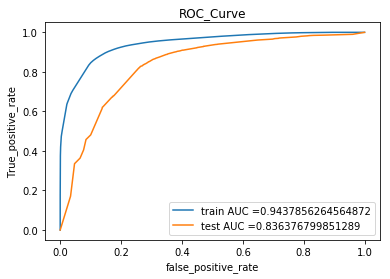

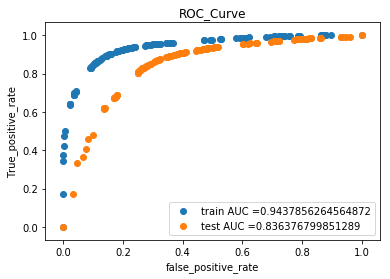

In [67]:
dtc = DecisionTreeClassifier(max_depth = optimal_alpha_auc[0],min_samples_split = optimal_alpha_auc[1])
dtc.fit(X_train_vect_tfidf, y_train)
pred = dtc.predict(X_test_vect_tfidf)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy formax_depth = %f and min_samples_split = %f is %f%%' % (optimal_alpha_auc[0],optimal_alpha_auc[1],acc))


train_fpr, train_tpr, thresholds = roc_curve(y_train, dtc.predict_proba(X_train_vect_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, dtc.predict_proba(X_test_vect_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)



Train confusion matrix
[[ 4508  1867]
 [ 1610 31415]]


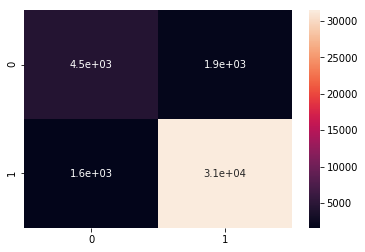

In [68]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cm_tr = confusion_matrix(y_train, dtc.predict(X_train_vect_tfidf))
sns.heatmap(cm_tr, annot=True)
print(cm_tr)

Train confusion matrix
[[ 2514  2157]
 [ 1805 22490]]


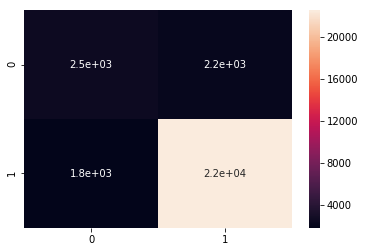

In [69]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cm_tr = confusion_matrix(y_test, dtc.predict(X_test_vect_tfidf))
sns.heatmap(cm_tr, annot=True)
print(cm_tr)

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [47]:
# Please write all the code with proper documentation
imp  = dtc.feature_importances_ 

vocab = list(tf_idf.get_feature_names())
imp_features = list(imp)
dict_new = {'Words':vocab,'imp_features':imp_features}
df_new = pd.DataFrame(dict_new)
df_pos_sorted =df_new.sort_values('imp_features', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
print("The top 20 important features are the following:")
print(df_pos_sorted[0:20])
print("\n")

The top 20 important features are the following:
             Words  imp_features
4820           not      0.131908
3217         great      0.080218
2148  disappointed      0.046510
746           best      0.036840
8054         worst      0.035300
4232          love      0.030247
3156          good      0.029220
1985     delicious      0.026794
605            bad      0.021072
3496      horrible      0.019477
589          awful      0.019030
4616         money      0.016564
4781          nice      0.015166
5211       perfect      0.013846
4237         loves      0.013613
2711      favorite      0.013069
2567     excellent      0.012932
7886         waste      0.011778
7218         tasty      0.011646
7280      terrible      0.011513




### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

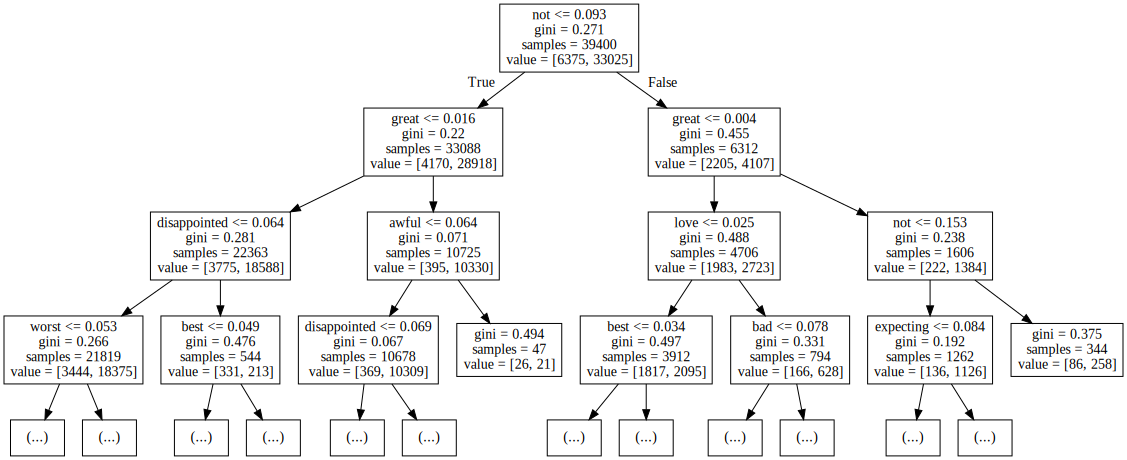

In [48]:
# Please write all the code with proper documentation
import graphviz
from sklearn import tree
import os
dot_data = tree.export_graphviz(dtc, out_file= None, max_depth=3, feature_names = vocab) 
graph = graphviz.Source(dot_data)
graph

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [49]:
# Please write all the code with proper documentation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

depth_in_range = [1,5,10,50,100,500,1000]
min_sample_split = [5,10,100,500]

parameters = [{'max_depth': [1,5,10,50,100,500,1000]},{'min_samples_split':[5,10,100,500]}]

model = GridSearchCV(DecisionTreeClassifier(),parameters, scoring = 'roc_auc')
model.fit(X_train_vectors, y_train)

print(model.best_estimator_)
print(model.score(X_test_vectors, y_test))


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.839527635871944


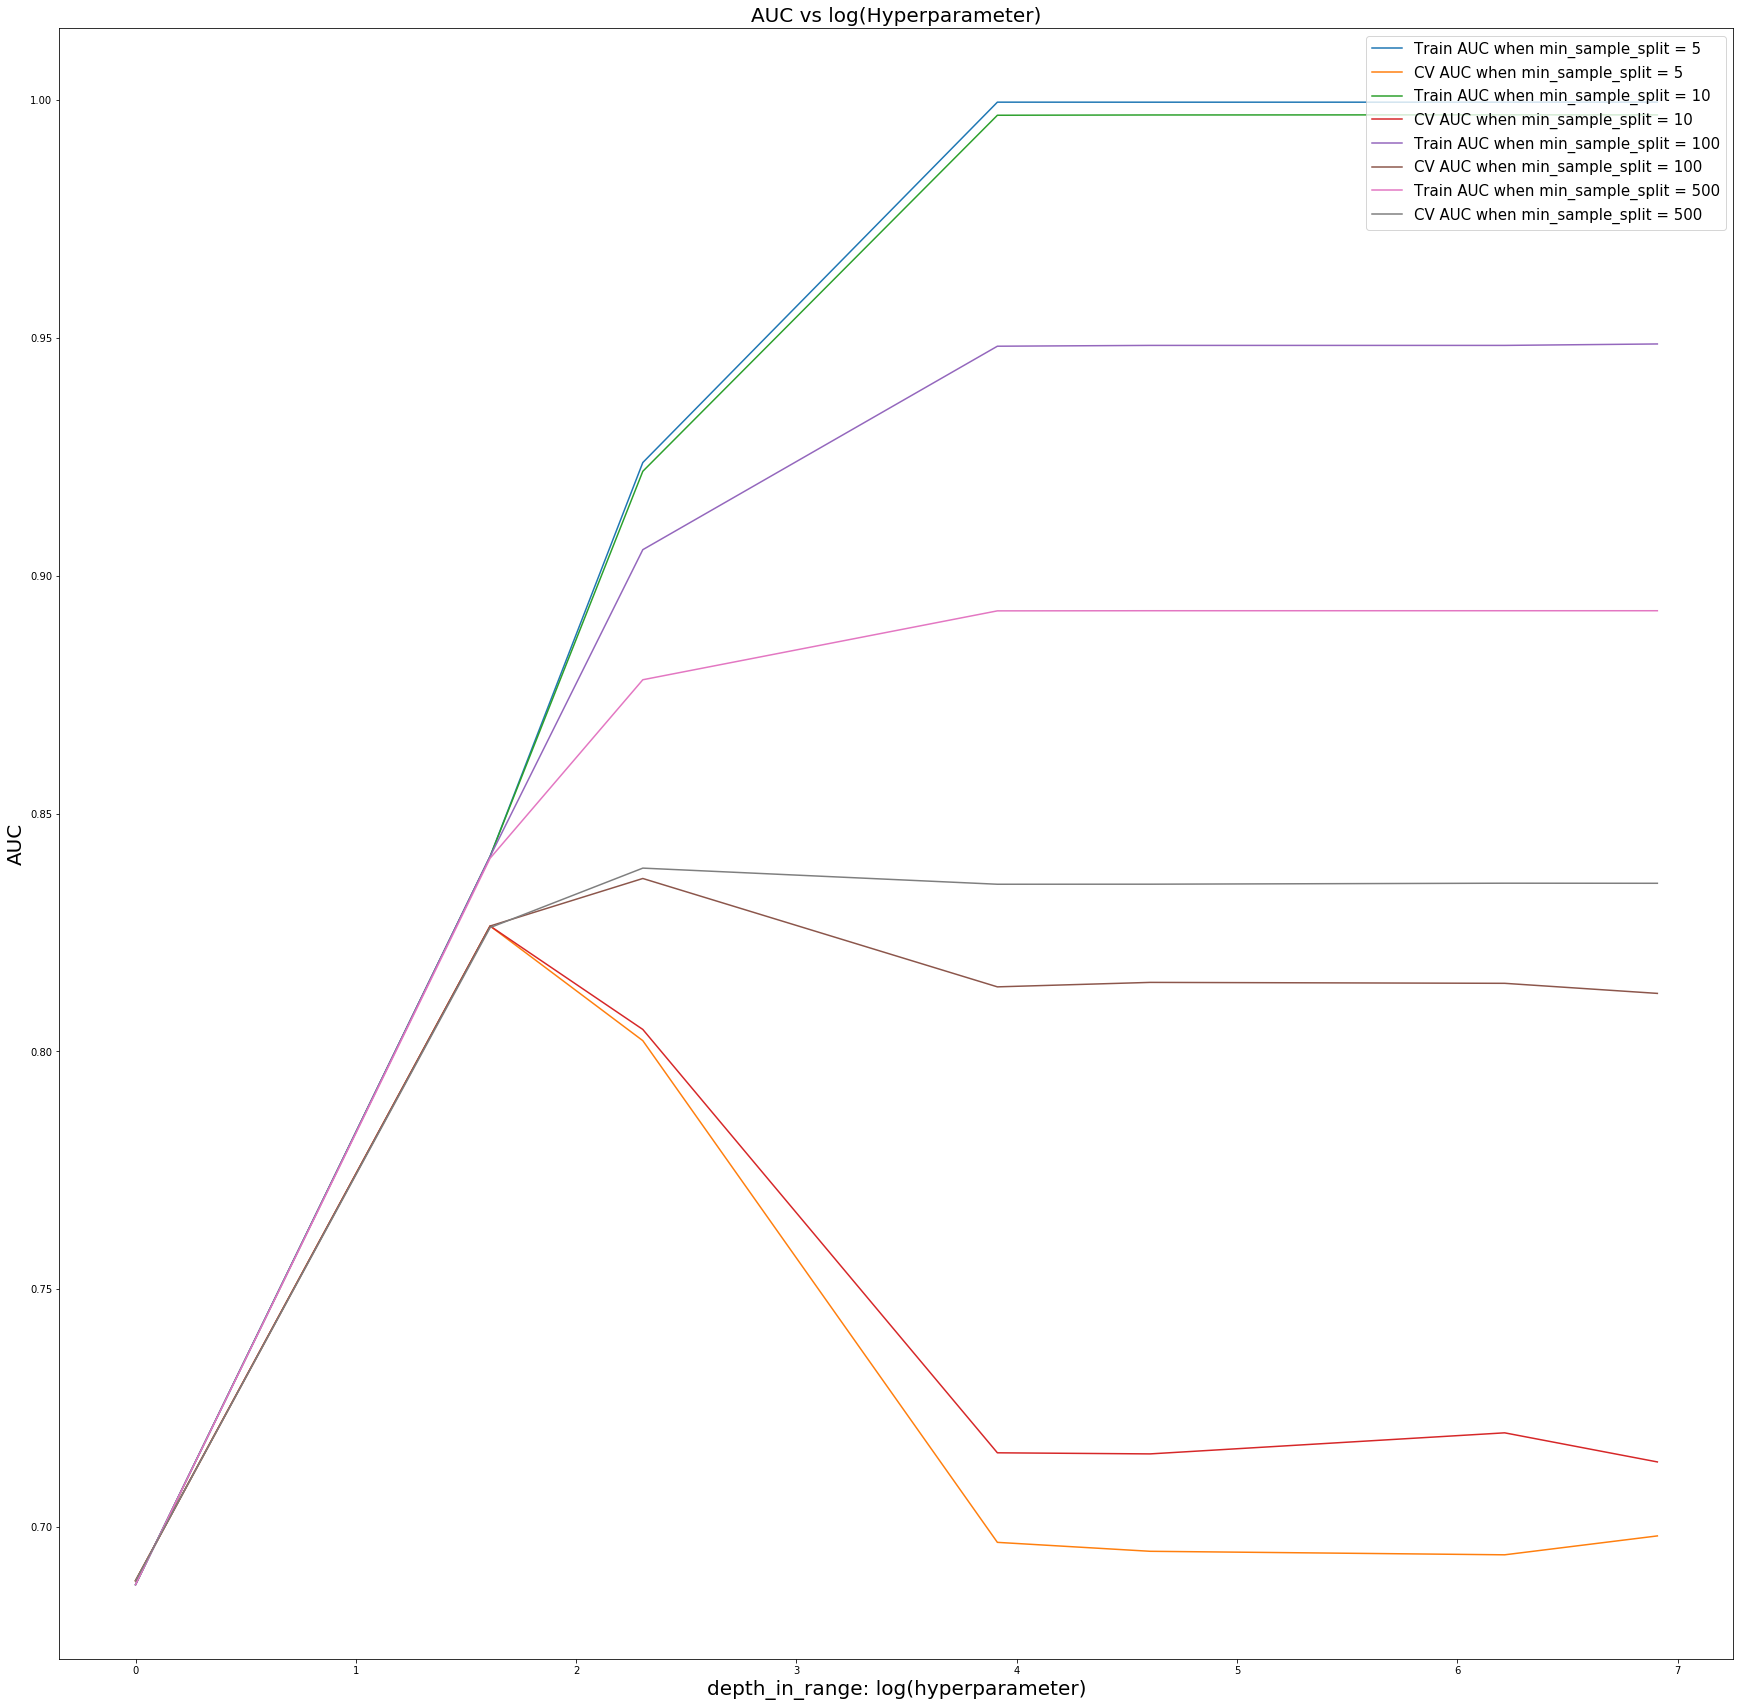

In [50]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
depth_in_range = [1,5,10,50,100,500,1000]
min_sample_split = [5,10,100,500]
ind = []
train_auc = []
cv_auc = []


plt.figure(figsize=(30,30))
for i in (min_sample_split):
    cv_auc_plot = []
    train_auc_plot = []
    for j in (depth_in_range):
        dtc = DecisionTreeClassifier(max_depth = j,min_samples_split = i)
        dtc.fit(X_train_vectors, y_train)
        y_train_pred =  dtc.predict_proba(X_train_vectors)[:,1]
        y_cv_pred =  dtc.predict_proba(X_cv_vectors)[:,1]
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        train_auc_plot.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        cv_auc_plot.append(roc_auc_score(y_cv, y_cv_pred))

    plt.plot(np.log(depth_in_range), train_auc_plot, label='Train AUC when min_sample_split = ' + str(i))
    plt.plot(np.log(depth_in_range), cv_auc_plot, label='CV AUC when min_sample_split = ' + str(i))
    
plt.legend(loc=1, prop={'size': 15})
plt.xlabel("depth_in_range: log(hyperparameter)",fontsize = 20)
plt.ylabel("AUC",fontsize = 20)
plt.title("AUC vs log(Hyperparameter)",fontsize = 20)
plt.show()

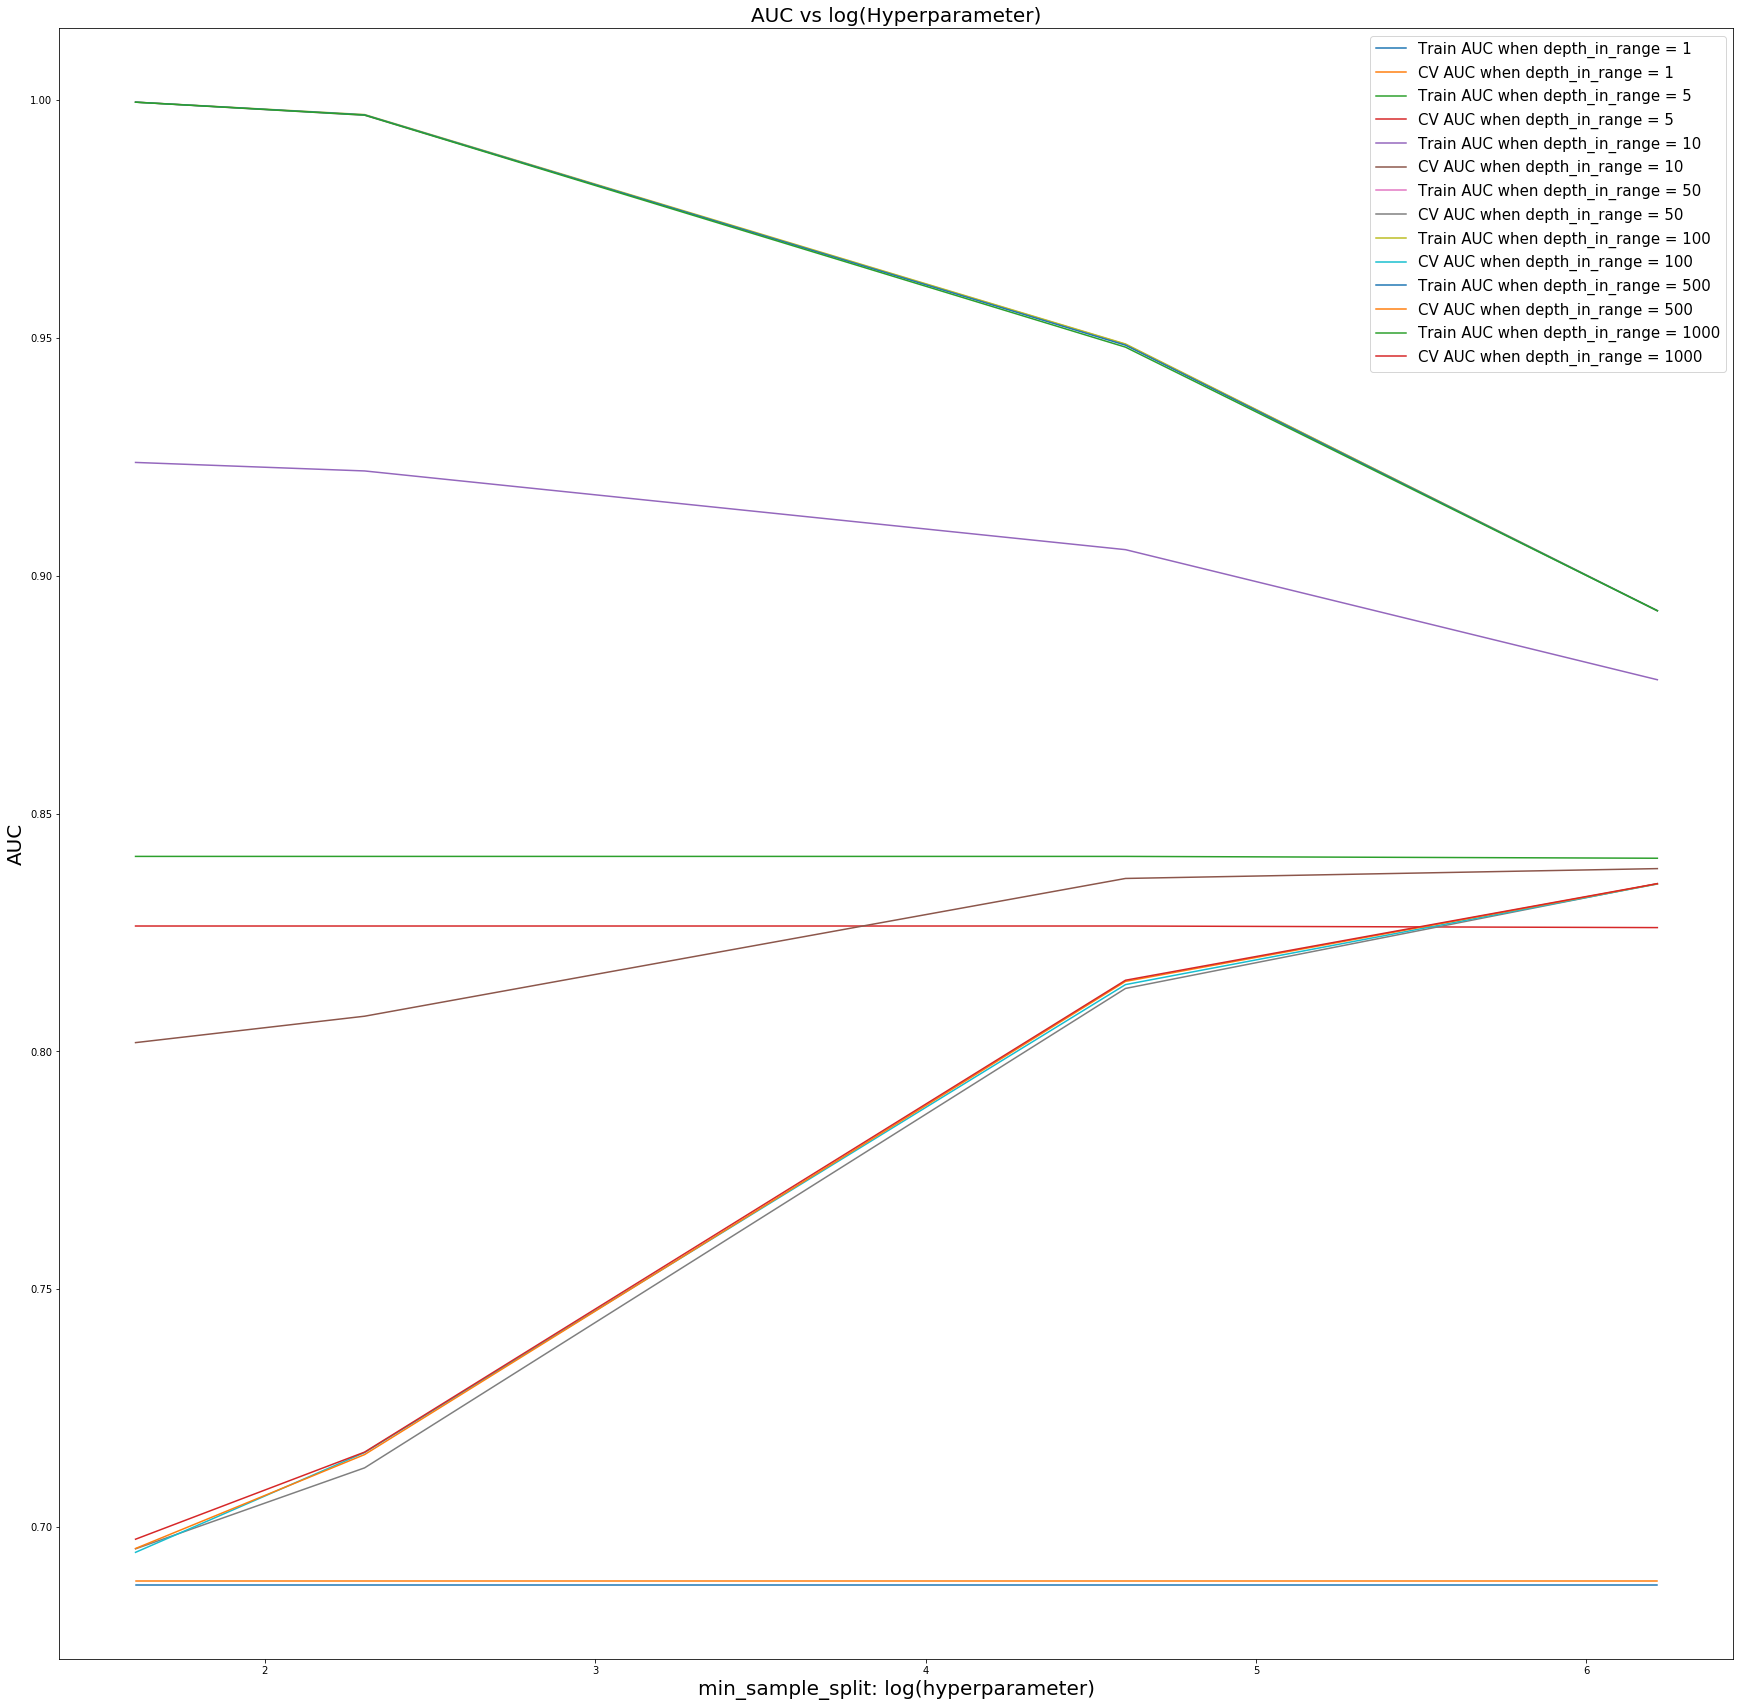

In [51]:

depth_in_range = [1,5,10,50,100,500,1000]
min_sample_split = [5,10,100,500]
count = 0;
ind = []
train_auc = []
cv_auc = []
hyp = []

plt.figure(figsize=(30,30))
for i in (depth_in_range):
    cv_auc_plot = []
    train_auc_plot = []
    for j in (min_sample_split):
        dtc = DecisionTreeClassifier(max_depth = i,min_samples_split = j)
        dtc.fit(X_train_vectors, y_train)
        ind.append(count)
        hyp.append([i,j])
        y_train_pred =  dtc.predict_proba(X_train_vectors)[:,1]
        y_cv_pred =  dtc.predict_proba(X_cv_vectors)[:,1]
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        train_auc_plot.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        cv_auc_plot.append(roc_auc_score(y_cv, y_cv_pred))
        count += 1
    

    plt.plot(np.log(min_sample_split), train_auc_plot, label='Train AUC when depth_in_range = ' + str(i))
    plt.plot(np.log(min_sample_split), cv_auc_plot, label='CV AUC when depth_in_range = ' + str(i))
    
plt.legend(loc=1, prop={'size': 15})
plt.xlabel("min_sample_split: log(hyperparameter)",fontsize = 20)
plt.ylabel("AUC",fontsize = 20)
plt.title("AUC vs log(Hyperparameter)",fontsize = 20)
plt.show()

In [52]:
optimal_alpha_auc = hyp[cv_auc.index(max(cv_auc))]
print('\nThe optimal max_depth is (according to auc curve (max auc)): ' , optimal_alpha_auc[0])
print('\nThe optimal min_sample_split is (according to auc curve (max auc)): ' , optimal_alpha_auc[1])



The optimal max_depth is (according to auc curve (max auc)):  10

The optimal min_sample_split is (according to auc curve (max auc)):  500



****Test accuracy formax_depth = 50.000000 and min_samples_split = 500.000000 is 85.938687%


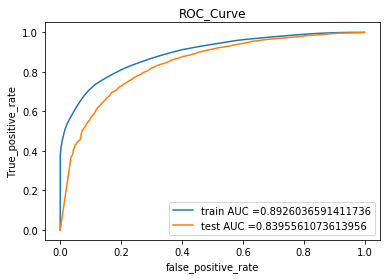

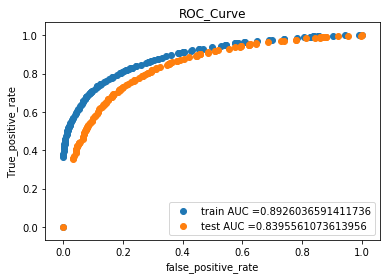

In [63]:
dtc = DecisionTreeClassifier(max_depth = optimal_alpha_auc[0],min_samples_split = optimal_alpha_auc[1])
dtc.fit(X_train_vectors, y_train)
pred = dtc.predict(X_test_vectors)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy formax_depth = %f and min_samples_split = %f is %f%%' % (optimal_alpha_auc[0],optimal_alpha_auc[1],acc))


train_fpr, train_tpr, thresholds = roc_curve(y_train, dtc.predict_proba(X_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, dtc.predict_proba(X_test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)


Train confusion matrix
[[ 2650  3725]
 [ 1328 31697]]


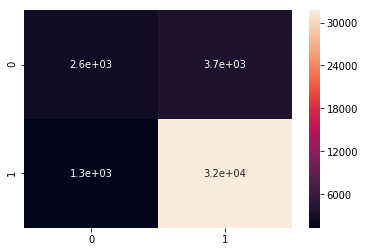

In [65]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cm_tr = confusion_matrix(y_train, dtc.predict(X_train_vectors))
sns.heatmap(cm_tr, annot=True)
print(cm_tr)

Train confusion matrix
[[ 1745  2926]
 [ 1147 23148]]


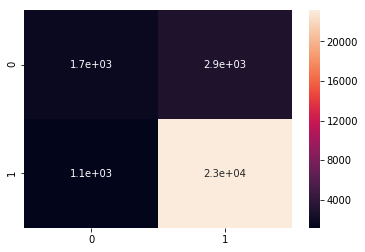

In [66]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cm_tr = confusion_matrix(y_test, dtc.predict(X_test_vectors))
sns.heatmap(cm_tr, annot=True)
print(cm_tr)

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [56]:
# Please write all the code with proper documentation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

depth_in_range = [1,5,10,50,100,500,1000]
min_sample_split = [5,10,100,500]

parameters = [{'max_depth': [1,5,10,50,100,500,1000]},{'min_samples_split':[5,10,100,500]}]

model = GridSearchCV(DecisionTreeClassifier(),parameters, scoring = 'roc_auc')
model.fit(tfidf_X_train_vectors, y_train)

print(model.best_estimator_)
print(model.score(tfidf_X_test_vectors, y_test))


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8096382468594454


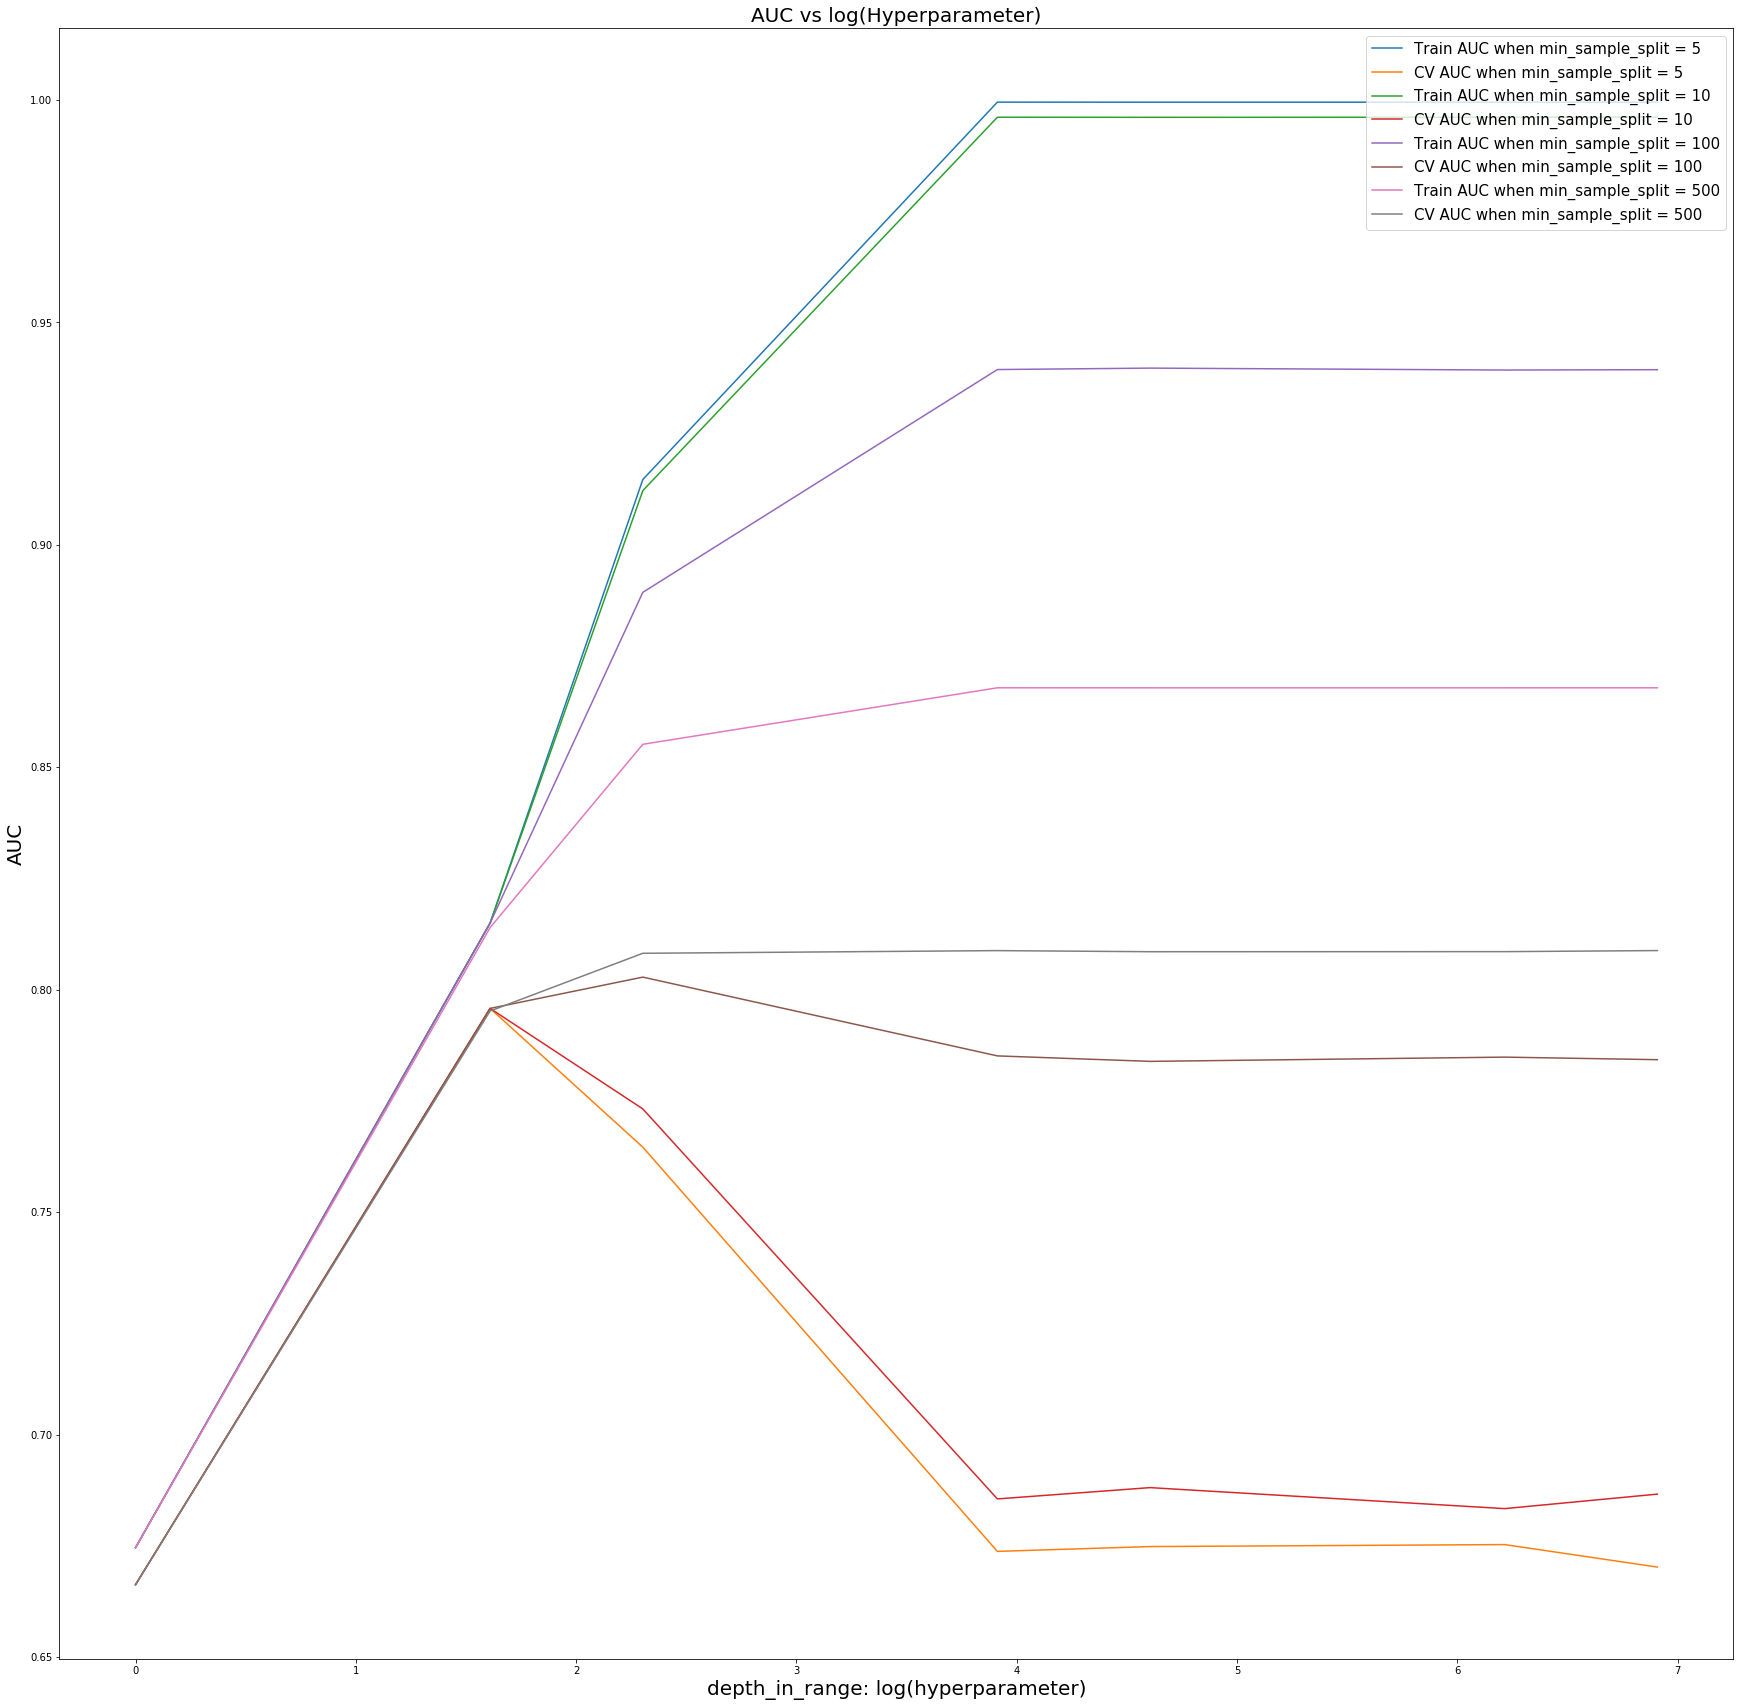

In [57]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
depth_in_range = [1,5,10,50,100,500,1000]
min_sample_split = [5,10,100,500]
ind = []
train_auc = []
cv_auc = []


plt.figure(figsize=(30,30))
for i in (min_sample_split):
    cv_auc_plot = []
    train_auc_plot = []
    for j in (depth_in_range):
        dtc = DecisionTreeClassifier(max_depth = j,min_samples_split = i)
        dtc.fit(tfidf_X_train_vectors, y_train)
        y_train_pred =  dtc.predict_proba(tfidf_X_train_vectors)[:,1]
        y_cv_pred =  dtc.predict_proba(tfidf_X_cv_vectors)[:,1]
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        train_auc_plot.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        cv_auc_plot.append(roc_auc_score(y_cv, y_cv_pred))

    plt.plot(np.log(depth_in_range), train_auc_plot, label='Train AUC when min_sample_split = ' + str(i))
    plt.plot(np.log(depth_in_range), cv_auc_plot, label='CV AUC when min_sample_split = ' + str(i))
    
plt.legend(loc=1, prop={'size': 15})
plt.xlabel("depth_in_range: log(hyperparameter)",fontsize = 20)
plt.ylabel("AUC",fontsize = 20)
plt.title("AUC vs log(Hyperparameter)",fontsize = 20)
plt.show()

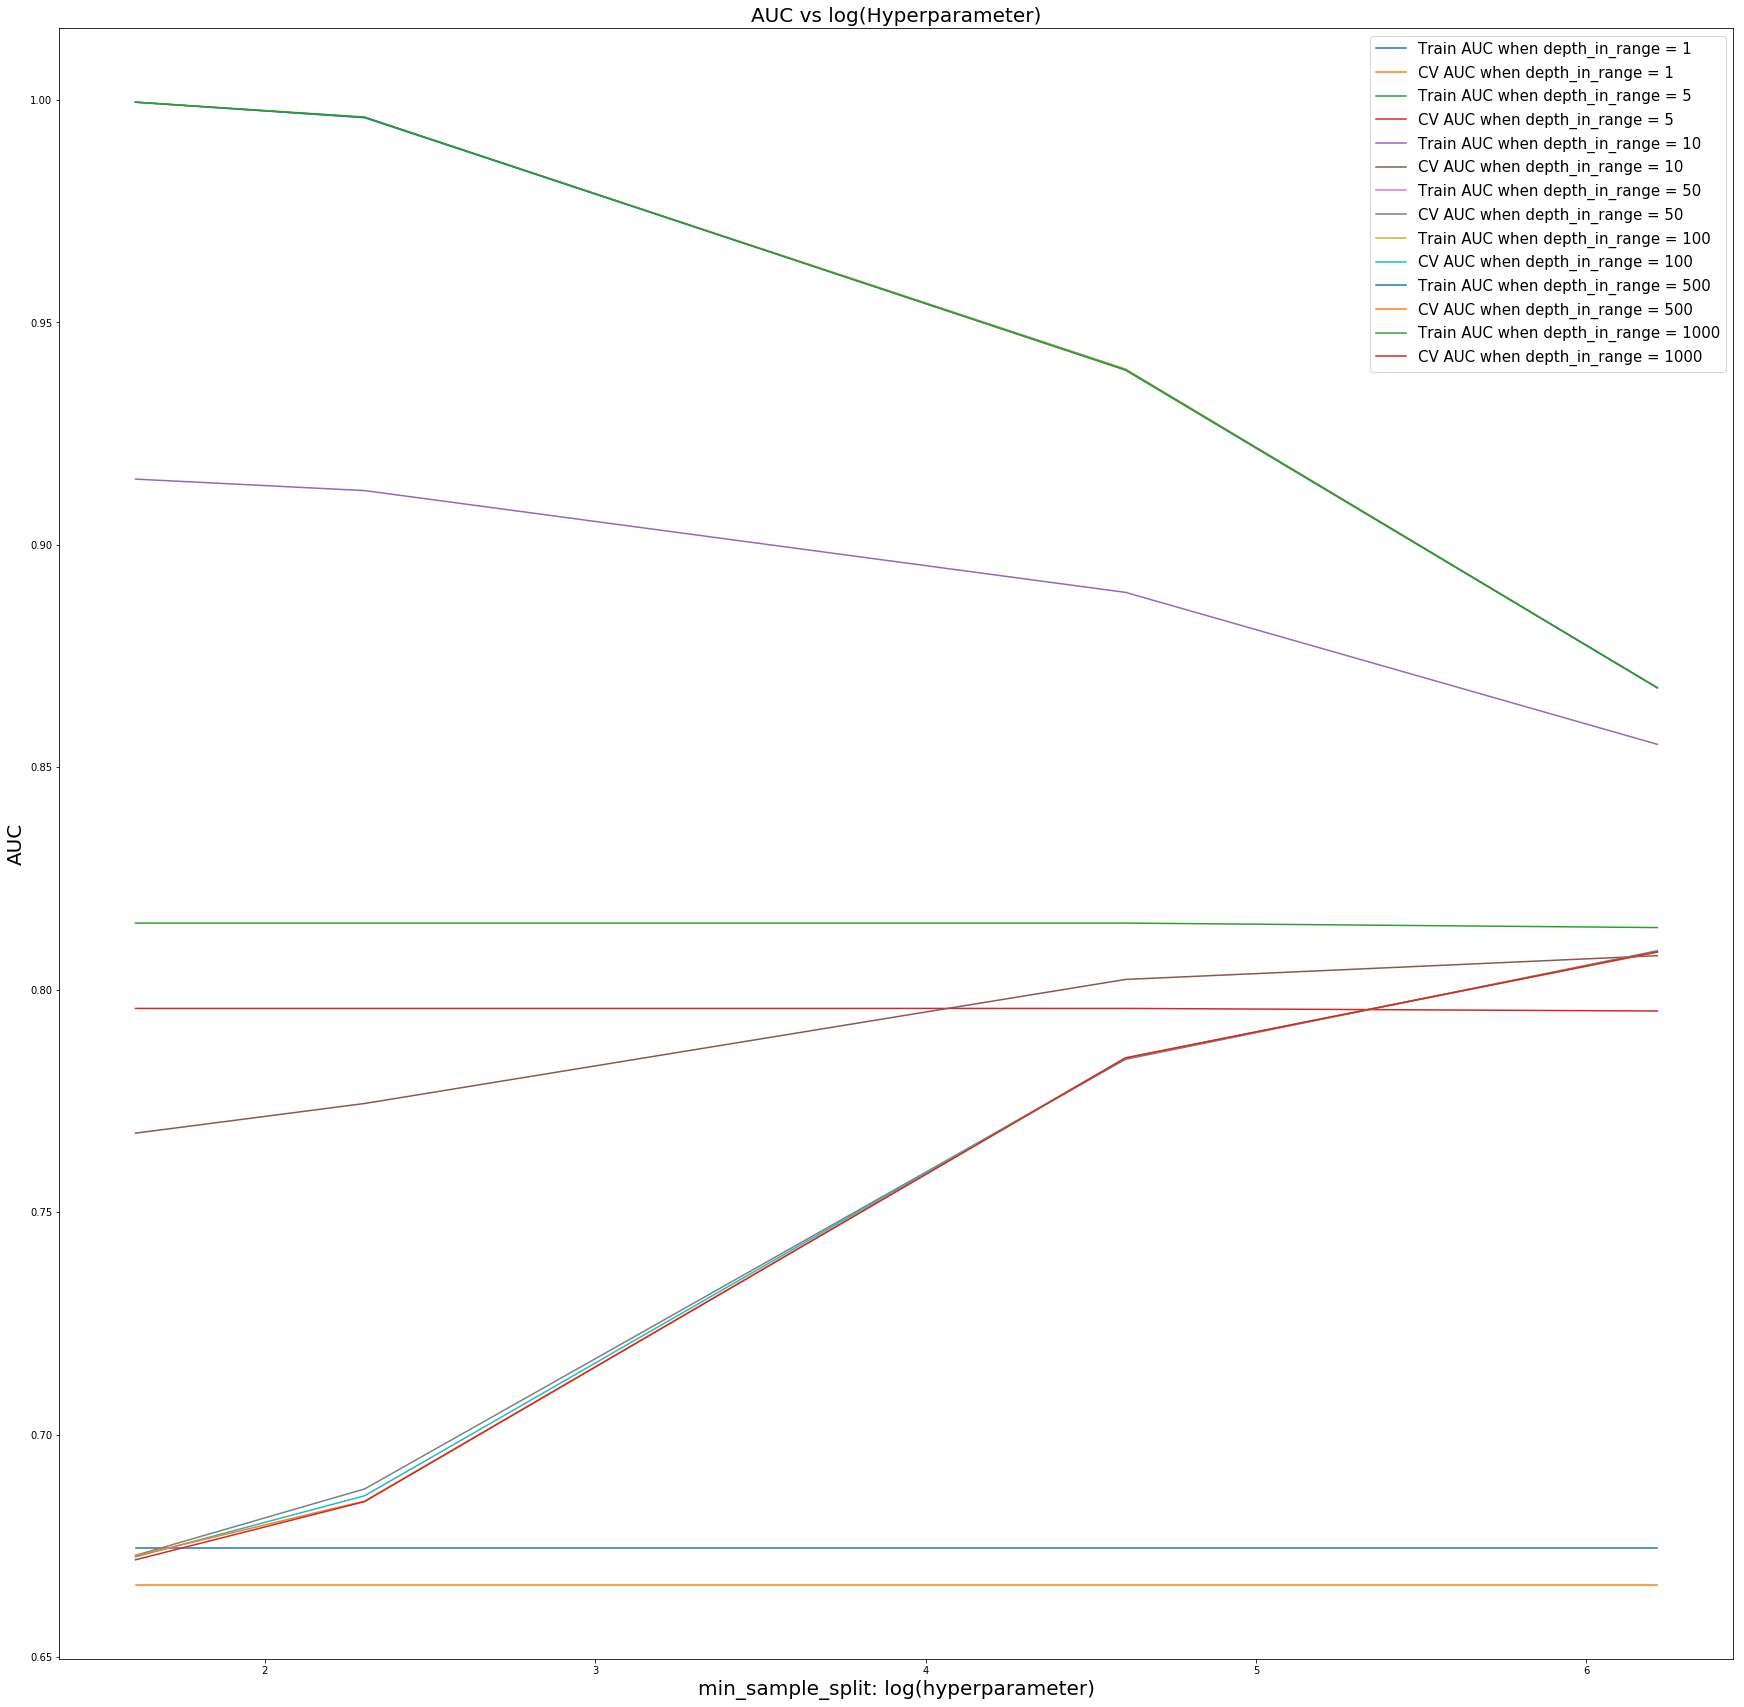

In [58]:

depth_in_range = [1,5,10,50,100,500,1000]
min_sample_split = [5,10,100,500]
count = 0;
ind = []
train_auc = []
cv_auc = []
hyp = []

plt.figure(figsize=(30,30))
for i in (depth_in_range):
    cv_auc_plot = []
    train_auc_plot = []
    for j in (min_sample_split):
        dtc = DecisionTreeClassifier(max_depth = i,min_samples_split = j)
        dtc.fit(tfidf_X_train_vectors, y_train)
        ind.append(count)
        hyp.append([i,j])
        y_train_pred =  dtc.predict_proba(tfidf_X_train_vectors)[:,1]
        y_cv_pred =  dtc.predict_proba(tfidf_X_cv_vectors)[:,1]
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        train_auc_plot.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        cv_auc_plot.append(roc_auc_score(y_cv, y_cv_pred))
        count += 1
    

    plt.plot(np.log(min_sample_split), train_auc_plot, label='Train AUC when depth_in_range = ' + str(i))
    plt.plot(np.log(min_sample_split), cv_auc_plot, label='CV AUC when depth_in_range = ' + str(i))
    
plt.legend(loc=1, prop={'size': 15})
plt.xlabel("min_sample_split: log(hyperparameter)",fontsize = 20)
plt.ylabel("AUC",fontsize = 20)
plt.title("AUC vs log(Hyperparameter)",fontsize = 20)
plt.show()

In [59]:
optimal_alpha_auc = hyp[cv_auc.index(max(cv_auc))]
print('\nThe optimal max_depth is (according to auc curve (max auc)): ' , optimal_alpha_auc[0])
print('\nThe optimal min_sample_split is (according to auc curve (max auc)): ' , optimal_alpha_auc[1])



The optimal max_depth is (according to auc curve (max auc)):  50

The optimal min_sample_split is (according to auc curve (max auc)):  500



****Test accuracy formax_depth = 50.000000 and min_samples_split = 500.000000 is 85.044535%


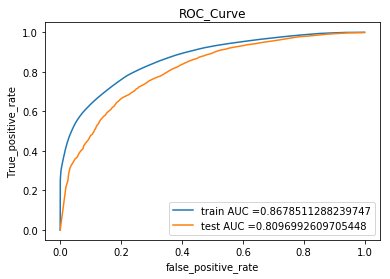

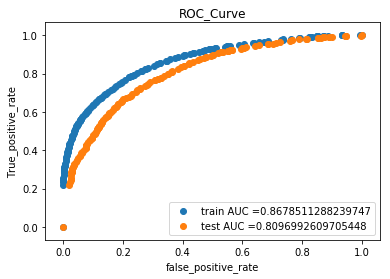

In [60]:
dtc = DecisionTreeClassifier(max_depth = optimal_alpha_auc[0],min_samples_split = optimal_alpha_auc[1])
dtc.fit(tfidf_X_train_vectors, y_train)
pred = dtc.predict(tfidf_X_test_vectors)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy formax_depth = %f and min_samples_split = %f is %f%%' % (optimal_alpha_auc[0],optimal_alpha_auc[1],acc))


train_fpr, train_tpr, thresholds = roc_curve(y_train, dtc.predict_proba(tfidf_X_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, dtc.predict_proba(tfidf_X_test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)


Train confusion matrix
[[ 2309  4066]
 [ 1290 31735]]


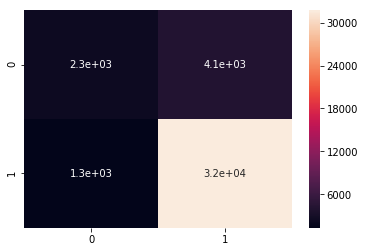

In [61]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cm_tr = confusion_matrix(y_train, dtc.predict(tfidf_X_train_vectors))
sns.heatmap(cm_tr, annot=True)
print(cm_tr)

Train confusion matrix
[[ 1465  3206]
 [ 1126 23169]]


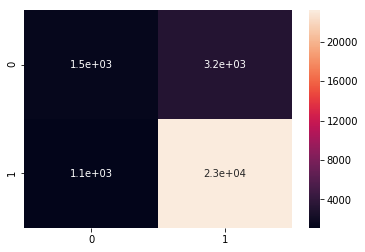

In [62]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cm_tr = confusion_matrix(y_test, dtc.predict(tfidf_X_test_vectors))
sns.heatmap(cm_tr, annot=True)
print(cm_tr)

# [6] Conclusions

In [74]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer", "max_depth", "min_samples_split", "AUC"]
x.add_row(["BOW", 50, 500, 0.85])
x.add_row(["TFIDF", 50, 500, 0.84])
x.add_row(["W2V", 50, 500, 0.84])
x.add_row(["TFIDFW2V", 50, 500, 0.80])
print(x)

+------------+-----------+-------------------+------+
| Vectorizer | max_depth | min_samples_split | AUC  |
+------------+-----------+-------------------+------+
|    BOW     |     50    |        500        | 0.85 |
|   TFIDF    |     50    |        500        | 0.84 |
|    W2V     |     50    |        500        | 0.84 |
|  TFIDFW2V  |     50    |        500        | 0.8  |
+------------+-----------+-------------------+------+
